In [1]:
from qiskit import qiskit
from numpy import pi
from myQFT import myQFT
from binToDez import binToDez, dezToBin
from gcd import gcd

In [2]:
def P_Gate(theta: float, controls: int = 0) -> qiskit.circuit.library.standard_gates.PhaseGate:
    """Returns a Phase Gate with *controls* many controlled inputs
        A single Qubit Phase Gate looks like this:
        ( 1        0     )
        ( 0  e^(i*theta) )

    Parameters:
    theta: float
        determines the phase shift
    controls: int
        defines the amount of control bits. Default = 0

    Returns: Phase Gate with *controls* many controlled inputs
    """
    if controls > 0:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(controls)
    else:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta)))

def calculate_A_Gate(target_bit_index: int,a_bin: list[int]) -> qiskit.circuit.library.standard_gates.PhaseGate:
    """Returns an Addition Gate for the quantum Addition as descriped by Beauregard(Stêphane Beauregard, Circuit for Shor’s algorithm using 2n+3 qubits, https://arxiv.org/pdf/quant-ph/0205095.pdf) 
        Infact this is a Phase Gate with added up theta's depending/controlled by the binary representation of the classically summand(a)
        The Gate operates on n+1 Qubits b contraining a n bit number to prevent overflow. So the input(before QFT) for the MSB should be |0>

    Parameters:
    target_bit_index: int
        Index of the target Qubit of the Quantum summand b. The Most significant Bit should be index 0 while the last element/Least significant Bit should have index n-1 while having a whole of n qubits.
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Most significant Bit & the last element the Least significant Bit. Example [1,0,0,0] to represent the decimal number 8.

    Returns: single Qubit Phase Gate 
    """
    theta, exponent, index_controller_bit = 0.0, 1, target_bit_index
    for _ in range(target_bit_index, len(a_bin)):
        if a_bin[index_controller_bit] == 1:
            theta+= 2*pi/(2**(exponent))
        exponent+=1
        index_controller_bit+=1
    return P_Gate(theta)

def quantum_classical_addition_Gate(a_bin: list[int]) -> qiskit.circuit.gate:
    """Creates a combination of A/Phase Gates which allow an addition of classical bits to a quantum register.

    Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Most significant Bit & the last element the Least significant Bit. Example [1,0,0,0] to represent the decimal number 8.

    Returns: Addition Gate
    """
    A_circuit = qiskit.QuantumCircuit(len(a_bin))
    for index in range(len(a_bin)):
        A_circuit.append(calculate_A_Gate(index,a_bin),[index])
    A_circuit = A_circuit.to_gate()
    A_circuit.name = "Add with " + str(binToDez(a_bin))
    return A_circuit

#Qubit 0,1 control, last qubit ancilla
def modular_adder_gate(a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.quantumcircuit:
    """Creates a modular adder Gate as an qiskit.circuit.quantumcircuit class. performs a+b Mod N in the fourier space. a is added classically while b is given as Qubits.
        The Gate has a total of 2 + len(a_bin) + 1 Qubits. The first ones are controll qubits, the varaible input is the lenght of the b qubits which needs to be the same as as len(a_bin).
        The last

        Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Most significant Bit & the last element the Least significant Bit. Example [1,0,0,0] to represent the decimal number 8.
    N_bin: list[int]
        Binary representation of the divisor N of the Modulo operation. The first element of the list needs to be the Most significant Bit & the last element the Least significant Bit. Example [1,0,0,0] to represent the decimal number 8.

    Returns: Modular adder gate as quantumcircuit
    """
    mod_add_gate = qiskit.QuantumCircuit(len(a_bin)+3)
    mod_add_gate.append(quantum_classical_addition_Gate(a_bin).control(2),[0,1] + list(range(2,len(a_bin)+2)))
    mod_add_gate.append(quantum_classical_addition_Gate(N_bin).inverse(),list(range(2,len(a_bin)+2)))
    myQFT(mod_add_gate,list(range(2,len(a_bin)+2)),inverse= True)
    mod_add_gate.cnot(2,len(a_bin)+2)
    myQFT(mod_add_gate,list(range(2,len(a_bin)+2)))
    mod_add_gate.append(quantum_classical_addition_Gate(N_bin).control(1),[len(a_bin)+2] + list(range(2,len(a_bin)+2)))
    #mod_add_gate.reset(len(a_bin)+2) #'One or more instructions cannot be converted to a gate. "reset" is not a gate instruction', verhindert Erstellung eines Gates. Komplexere Lösung des Qubit reset möglich
    mod_add_gate.append(quantum_classical_addition_Gate(a_bin).control(2).inverse(),[0,1] + list(range(2,len(a_bin)+2)))
    mod_add_gate.name = "Add with " + str(binToDez(a_bin)) + " Mod " + str(binToDez(N_bin))
    myQFT(mod_add_gate,list(range(2,len(a_bin)+2)),inverse= True)
    mod_add_gate.x(2)
    mod_add_gate.cnot(2,len(a_bin)+2)
    mod_add_gate.x(2)
    myQFT(mod_add_gate,list(range(2,len(a_bin)+2)))
    mod_add_gate.append(quantum_classical_addition_Gate(a_bin).control(2),[0,1] + list(range(2,len(a_bin)+2)))
    return mod_add_gate
    

def controlled_multiplier_gate(a_bin: list[int],N_bin: list[int],x: int) -> qiskit.circuit.quantumcircuit:
    """
    Returns the controlled_multiplier_gate
    The gate takes 1 (c) + x many control Qubits on index 0 to len(x). The x controll bits represent the multiplier in (b+a*x) Mod N. The first bit of x is the MSB while the last is the LSB, so the second bit(the bit after c ) is MSB of the whole x register. 
    The gate needs one ancilla qubit for the underlying gates. This is the last Qubit of this Circuite
    """
    a_dez = binToDez(a_bin)
    N_dez = binToDez(N_bin)
    #Creates Circuite with 1 + x controll Quits and len(a_bin) (which should be the same as len(b_bin)) many input qubits + 1 ancilla Qubit for the modular adder
    cmult_mod_gate = qiskit.QuantumCircuit(1 + x + len(a_bin) + 1)
    myQFT(cmult_mod_gate,list(range(1+x,1+x+len(a_bin))))
    exponent = x
    for control in range(1, 1 + x):
        a = int(a_dez * (2**(exponent-1))) % N_dez
        exponent-=1
        summand = dezToBin(a, len(a_bin))
        cmult_mod_gate.append(modular_adder_gate(summand,N_bin),[0] + [control] + list(range(1+x,1+x+len(a_bin)+ 1)))
    myQFT(cmult_mod_gate,list(range(1+x,1+x+len(a_bin))),inverse= True)
    return cmult_mod_gate

#Index 0 ist Controll .Indexes 1 bis x für X bits. x+1 bis 2x +1 sind |0> Bits, 2x+2 Bit bzw letztes ist das Ancilla Qubit
def controlled_Ua_gate(a_bin: list[int],N_bin: list[int],x: int) -> qiskit.circuit.quantumcircuit:
    a_dez = binToDez(a_bin)
    a_dez_inv = gcd(a_dez, binToDez(N_bin))
    controlled_Ua_gate = qiskit.QuantumCircuit(1 + x + len(a_bin) + 1)
    controlled_Ua_gate.append(controlled_multiplier_gate(a_bin,N_bin,x),list(range(1 + x + len(a_bin) + 1)))
    for i in range(1,1+x):
        controlled_Ua_gate.swap(i,i+x+1)
    controlled_Ua_gate.append(controlled_multiplier_gate(dezToBin(a_dez_inv,len(a_bin)),N_bin,x).inverse(),list(range(1 + x + len(a_bin) + 1)))
    #controlled_Ua_gate = controlled_Ua_gate.to_gate()
    controlled_Ua_gate.name = "U_a^" + str(a_dez)
    return controlled_Ua_gate

In [3]:
from qiskit.visualization import plot_histogram

In [54]:
qc = qiskit.QuantumCircuit(18,8)
qc.x(11)
for i in range(0,8):
    qc.h(i)
x = 7
for i in range(0,8):
    inner = pow(2,i,15-1)
    qc.append(controlled_Ua_gate(dezToBin(pow(7,inner,15), 5),[0,1,1,1,1],4),[i,8,9,10,11,12,13,14,15,16,17])
    x-=1
qc.barrier()
myQFT(qc,(list(reversed(range(0,8)))),inverse= True)
qc.barrier()
qc.measure(range(8),range(8))
qc.draw()

┌───┐┌─────────┐                                                       »
 q_0: ┤ H ├┤0        ├───────────────────────────────────────────────────────»
      ├───┤│         │┌─────────┐                                            »
 q_1: ┤ H ├┤         ├┤0        ├────────────────────────────────────────────»
      ├───┤│         ││         │┌─────────┐                                 »
 q_2: ┤ H ├┤         ├┤         ├┤0        ├─────────────────────────────────»
      ├───┤│         ││         ││         │┌─────────┐                      »
 q_3: ┤ H ├┤         ├┤         ├┤         ├┤0        ├──────────────────────»
      ├───┤│         ││         ││         ││         │┌─────────┐           »
 q_4: ┤ H ├┤         ├┤         ├┤         ├┤         ├┤0        ├───────────»
      ├───┤│         ││         ││         ││         ││         │┌─────────┐»
 q_5: ┤ H ├┤         ├┤         ├┤         ├┤         ├┤         ├┤0        ├»
      ├───┤│         ││         ││         ││         ││         ││         │»
 q_6: ┤ H ├┤         ├┤         ├┤         ├┤         ├┤         ├┤         ├»
      ├───┤│         ││         ││         ││         ││         ││         │»
 q_7: ┤ H ├┤         ├┤         ├┤         ├┤         ├┤         ├┤         ├»
      └───┘│         ││         ││         ││         ││         ││         │»
 q_8: ─────┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├»
           │   U_a^7 ││         ││         ││         ││         ││         │»
 q_9: ─────┤2        ├┤2  U_a^4 ├┤2        ├┤2        ├┤2        ├┤2        ├»
           │         ││         ││   U_a^1 ││         ││         ││         │»
q_10: ─────┤3        ├┤3        ├┤3        ├┤3  U_a^1 ├┤3        ├┤3        ├»
      ┌───┐│         ││         ││         ││         ││   U_a^4 ││         │»
q_11: ┤ X ├┤4        ├┤4        ├┤4        ├┤4        ├┤4        ├┤4  U_a^1 ├»
      └───┘│         ││         ││         ││         ││         ││         │»
q_12: ─────┤5        ├┤5        ├┤5        ├┤5        ├┤5        ├┤5        ├»
           │         ││         ││         ││         ││         ││         │»
q_13: ─────┤6        ├┤6        ├┤6        ├┤6        ├┤6        ├┤6        ├»
           │         ││         ││         ││         ││         ││         │»
q_14: ─────┤7        ├┤7        ├┤7        ├┤7        ├┤7        ├┤7        ├»
           │         ││         ││         ││         ││         ││         │»
q_15: ─────┤8        ├┤8        ├┤8        ├┤8        ├┤8        ├┤8        ├»
           │         ││         ││         ││         ││         ││         │»
q_16: ─────┤9        ├┤9        ├┤9        ├┤9        ├┤9        ├┤9        ├»
           │         ││         ││         ││         ││         ││         │»
q_17: ─────┤10       ├┤10       ├┤10       ├┤10       ├┤10       ├┤10       ├»
           └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
 c: 8/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                             ░ ┌───┐                                   »
« q_0: ───────────────────────░─┤ H ├─■──────────────■──────────────────»
«                             ░ └───┘ │P(-π/2) ┌───┐ │                  »
« q_1: ───────────────────────░───────■────────┤ H ├─┼─────────■────────»
«                             ░                └───┘ │P(-π/4)  │P(-π/2) »
« q_2: ───────────────────────░──────────────────────■─────────■────────»
«                             ░                                         »
« q_3: ───────────────────────░─────────────────────────────────────────»
«                             ░                                         »
« q_4: ───────────────────────░─────────────────────────────────────────»
«                             ░                                         »
« q_5: ───────────────────────░─────────────────────────────────────────»
«      ┌─────────┐            ░      

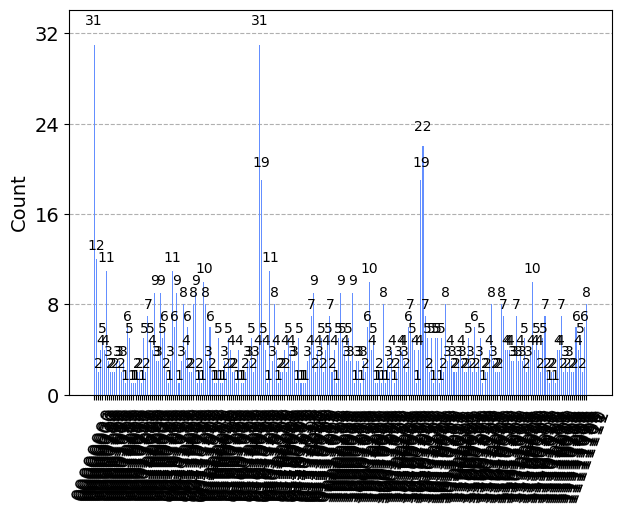

In [55]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

In [56]:
from math import gcd as gcd_math
import pandas as pd
from fractions import Fraction
N_COUNT = 8
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

              Register Output           Phase
0    01000010(bin) =  66(dec)   66/256 = 0.26
1    00010010(bin) =  18(dec)   18/256 = 0.07
2    00111111(bin) =  63(dec)   63/256 = 0.25
3    00011000(bin) =  24(dec)   24/256 = 0.09
4    01111100(bin) = 124(dec)  124/256 = 0.48
..                        ...             ...
234  00110101(bin) =  53(dec)   53/256 = 0.21
235  10101101(bin) = 173(dec)  173/256 = 0.68
236  00110001(bin) =  49(dec)   49/256 = 0.19
237  11010010(bin) = 210(dec)  210/256 = 0.82
238  10101111(bin) = 175(dec)  175/256 = 0.68

[239 rows x 2 columns]


In [57]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    if frac.denominator == 4:
        rows.append([phase,
                     f"{frac.numerator}/{frac.denominator}",
                     frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Phase Fraction  Guess for r
0  0.257812      1/4            4
1  0.246094      1/4            4
2  0.242188      1/4            4
3  0.750000      3/4            4
4  0.746094      3/4            4
5  0.250000      1/4            4
6  0.753906      3/4            4
